In [1]:
### library import
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL

import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

from timm import create_model

### Prepare Model and Data

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device =", device)

model_name = 'vit_base_patch16_224'
model = create_model(model_name, pretrained=True).to(device)

device = cpu


In [3]:
# Define transforms for test
IMG_SIZE = (224, 224)
NORMALIZE_MEAN = (0.5, 0.5, 0.5)
NORMALIZE_STD = (0.5, 0.5, 0.5)
transforms = [
                T.Resize(IMG_SIZE),
                T.ToTensor(),
                T.Normalize(NORMALIZE_MEAN, NORMALIZE_STD)
]
transforms = T.Compose(transforms)

In [4]:
%%capture
# ImageNet Labels
# !wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
imagenet_labels  = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))

# Demo Image
# !wget https://github.com/hirotomusiker/schwert_colab_data_storage/blob/master/images/vit_demo/santorini.png?raw=true -O santorini.png
img = PIL.Image.open('santorini.png')
img_tensor = transforms(img).unsqueeze(0).to(device)

### Split Image into patches

Image tensor:  torch.Size([1, 3, 224, 224])
Patch embeddings:  torch.Size([1, 196, 768])
224 224 3


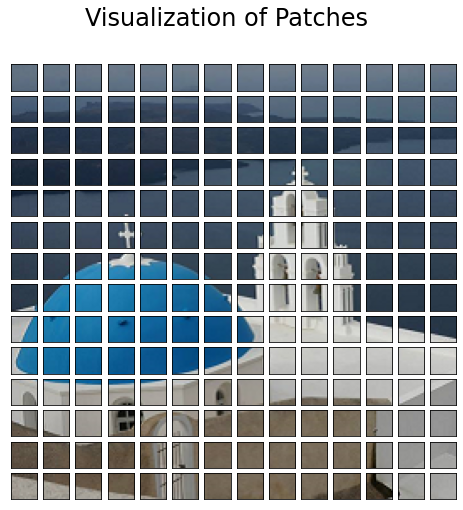

In [5]:
patches = model.patch_embed(img_tensor) # patch embedding convolution
print("Image tensor: ", img_tensor.shape)
print("Patch embeddings: ", patches.shape) # 16*16*3 = 768

# This is NOT a part of the pipeline.
# Actually the image is divided into patch embeddings by Conv2d
# with stride=(16, 16) shown above. 
fig = plt.figure(figsize=(8, 8))
fig.suptitle("Visualization of Patches", fontsize=24)
fig.add_axes()
img = np.asarray(img)
print(len(img), len(img[0]), len(img[0][0]))

for i in range(0, 196): # number of patches 
    x = i % 14 # 한줄에 14개씩 
    y = i // 14
    patch = img[y*16:(y+1)*16, x*16:(x+1)*16]
    ax = fig.add_subplot(14, 14, i+1)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(patch)


### Add Position Embeddings

torch.Size([1, 197, 768])
Transformer input:  torch.Size([1, 197, 768])


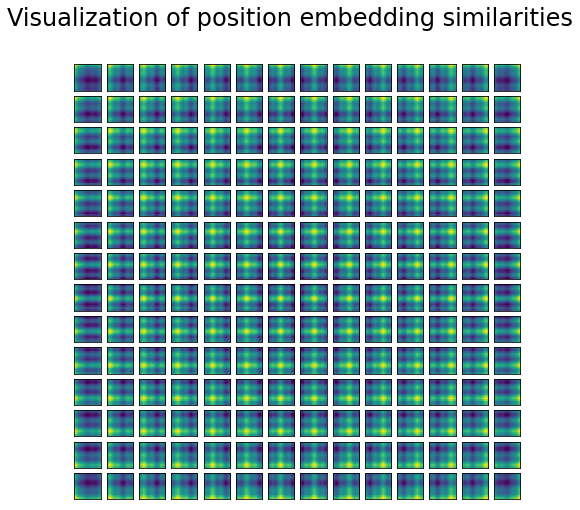

In [6]:
pos_embed = model.pos_embed
print(pos_embed.shape)

# Visualize position embedding similarities.
# One cell shows cos similarity between an embedding and all the other embeddings.
fig = plt.figure(figsize=(8, 8))
fig.suptitle("Visualization of position embedding similarities", fontsize=24)

for i in range(1, pos_embed.shape[1]): # number of patches except class token
    sim = F.cosine_similarity(pos_embed[0, i:i+1], pos_embed[0, 1:], dim=1)
    sim = sim.reshape((14, 14)).detach().cpu().numpy()
    ax = fig.add_subplot(14, 14, i)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(sim)

transformer_input = torch.cat((model.cls_token, patches), dim=1) + pos_embed # embedded patches
print("Transformer input: ", transformer_input.shape)

### Transformer
12번의 encoder 수행

In [7]:
print("input tensor to Transformer (z0): ", transformer_input.shape)
x = transformer_input.clone()

for i, blk in enumerate(model.blocks):
    print("Entering the Transformer Encoder {}".format(i))
    x = blk(x)

x = model.norm(x)
print(x.shape)
transformer_output = x[:, 0] # class token
print("Output vectore from Transformer (z12-0):", transformer_output.shape)

input tensor to Transformer (z0):  torch.Size([1, 197, 768])
Entering the Transformer Encoder 0
Entering the Transformer Encoder 1
Entering the Transformer Encoder 2
Entering the Transformer Encoder 3
Entering the Transformer Encoder 4
Entering the Transformer Encoder 5
Entering the Transformer Encoder 6
Entering the Transformer Encoder 7
Entering the Transformer Encoder 8
Entering the Transformer Encoder 9
Entering the Transformer Encoder 10
Entering the Transformer Encoder 11
torch.Size([1, 197, 768])
Output vectore from Transformer (z12-0): torch.Size([1, 768])


### How to Attention works

In [8]:
print("Transformer Multi-head Attension block:")
attention = model.blocks[0].attn
print(attention)
print("input of the transformer encoder:", transformer_input.shape) 

Transformer Multi-head Attension block:
Attention(
  (qkv): Linear(in_features=768, out_features=2304, bias=True)
  (attn_drop): Dropout(p=0.0, inplace=False)
  (proj): Linear(in_features=768, out_features=768, bias=True)
  (proj_drop): Dropout(p=0.0, inplace=False)
)
input of the transformer encoder: torch.Size([1, 197, 768])


In [9]:
# fc layer to expand the dimension
transformer_input_expanded  =  attention.qkv(transformer_input)[0]
print("expanded to:", transformer_input_expanded.shape) # 768*3 = 2304

expanded to: torch.Size([197, 2304])


In [10]:
# Split qkv into multiple q, k and v vectors for multi-head attension
qkv = transformer_input_expanded.reshape(197, 3, 12, 64) # (N=197, (qkv), H=12, D/H=64)
print("split qkv : ", qkv.shape)
q = qkv[:, 0].permute(1, 0, 2) # (H=12, N=197, D/H=64)
k = qkv[:, 1].permute(1, 0, 2) # (H=12, N=197, D/H=64)
kT = k.permute(0, 2, 1)  # (H=12, D/H=64, N=197)
print("transposed ks: ", kT.shape)

split qkv :  torch.Size([197, 3, 12, 64])
transposed ks:  torch.Size([12, 64, 197])


attention matrix:  torch.Size([12, 197, 197])


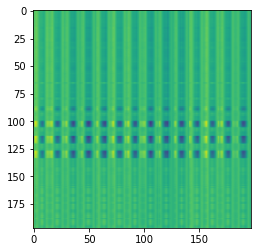

In [11]:
# Attention Matrix 
attention_matrix = q @ kT # matmul
print("attention matrix: ", attention_matrix.shape)
plt.imshow(attention_matrix[3].detach().cpu().numpy())

### Visualize

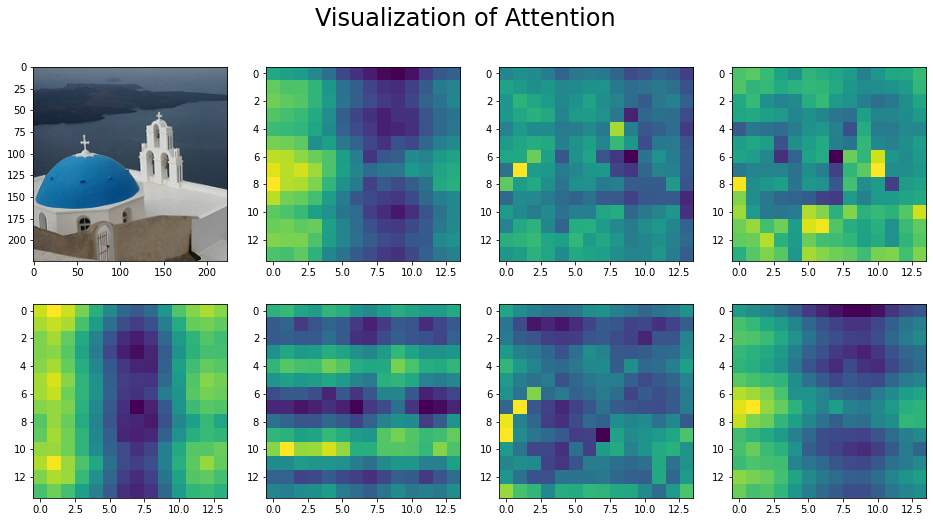

In [12]:
# Visualize attention matrix
fig = plt.figure(figsize=(16, 8))
fig.suptitle("Visualization of Attention", fontsize=24)
fig.add_axes()
img = np.asarray(img)
ax = fig.add_subplot(2, 4, 1)
ax.imshow(img)

for i in range(7): # visualize the 100th rows of attention matrices in the 0-7th heads
    attn_heatmap = attention_matrix[i, 100, 1:].reshape((14, 14)).detach().cpu().numpy()
    ax = fig.add_subplot(2, 4, i+2)
    ax.imshow(attn_heatmap)

### Print the classification results
This problem has 1000 classification labels

Classfication head:  Linear(in_features=768, out_features=1000, bias=True)
Inference result : id = 538, label name = dome



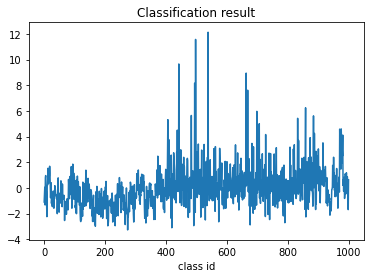

In [13]:
print("Classfication head: ", model.head) # 1000 classification labels
result = model.head(transformer_output)
result_label_id = int(torch.argmax(result))
plt.plot(result.detach().cpu().numpy()[0])
plt.title("Classification result")
plt.xlabel("class id")
print("Inference result : id = {}, label name = {}".format(
    result_label_id, imagenet_labels[result_label_id]
))